In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')

In [2]:
from sys import path
path.append('..')
from convexcontrol.main import Controller
from convexcontrol.resources import PVSys, Battery, TCL

In [3]:
agg_point = np.zeros(200)
agg_point[:40] = np.linspace(-40, 40, 40)
agg_point[40:60] = np.linspace(40, 0, 20)
agg_point[100:125] = 20.
agg_point[125:130] = 25.
agg_point[130:135] = 30.
agg_point[135:140] = 35.
agg_point[140:145] = 30.
agg_point[145:150] = 25.
agg_point[150:175] = -25.
agg_point[175:200] = -50.

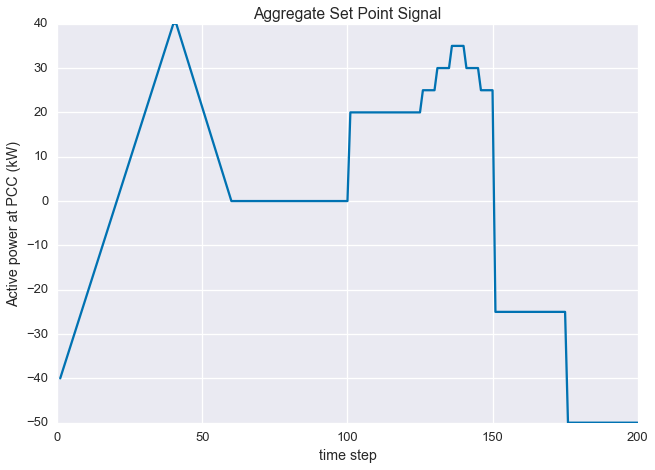

In [4]:
plt.plot(figsize=(14, 8))
plt.plot(range(1, 201), agg_point)
plt.xlabel('time step')
plt.ylabel('Active power at PCC (kW)')
plt.title('Aggregate Set Point Signal')

In [5]:
controller = Controller(mu=1e3)

In [6]:
controller.addResource(PVSys('pv1', T=201))
controller.addResource(Battery('batt1', Cb=1e-1))
controller.addResource(TCL('hvac1', Chvac=1e-1))

In [7]:
controller.runSimulation(agg_point, error_diffusion=False, solver='MOSEK')

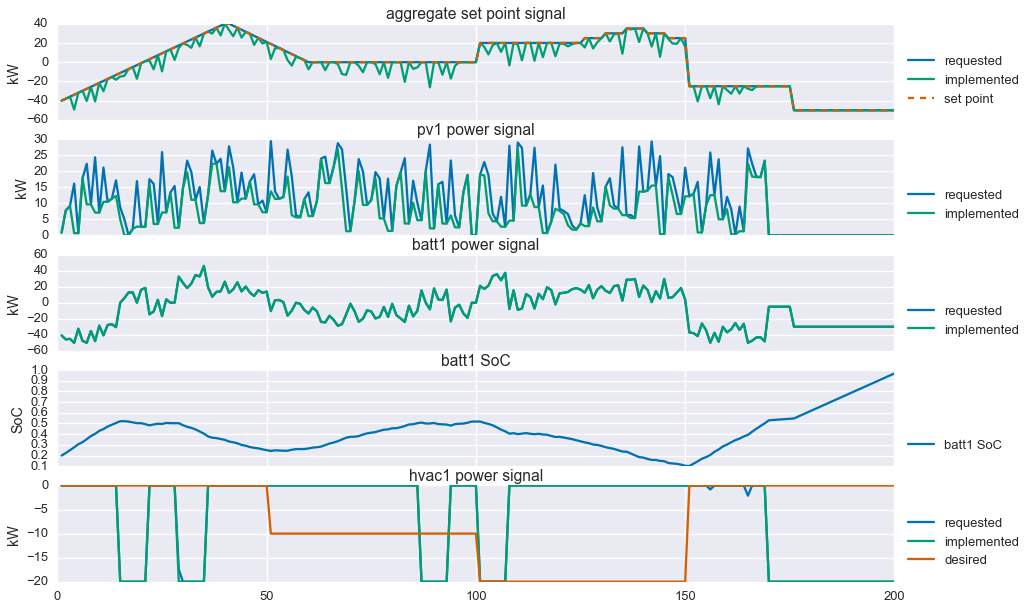

In [8]:
_ = controller.plotReqImpPower()
plt.show()

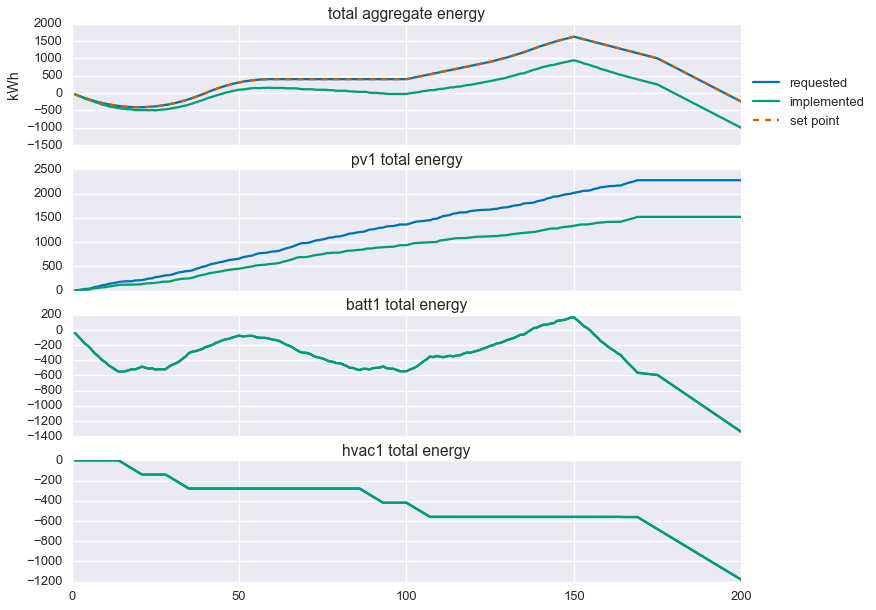

In [9]:
_ = controller.plotReqImpTotalEnergy()
plt.show()

In [10]:
controll_diffuse = Controller(mu=1e3)
controll_diffuse.addResource(PVSys('pv2', T=201))
controll_diffuse.addResource(Battery('batt2', Cb=1e-1))
controll_diffuse.addResource(TCL('hvac2', Chvac=1e-1))

In [11]:
controll_diffuse.runSimulation(agg_point, error_diffusion=True, solver='MOSEK')

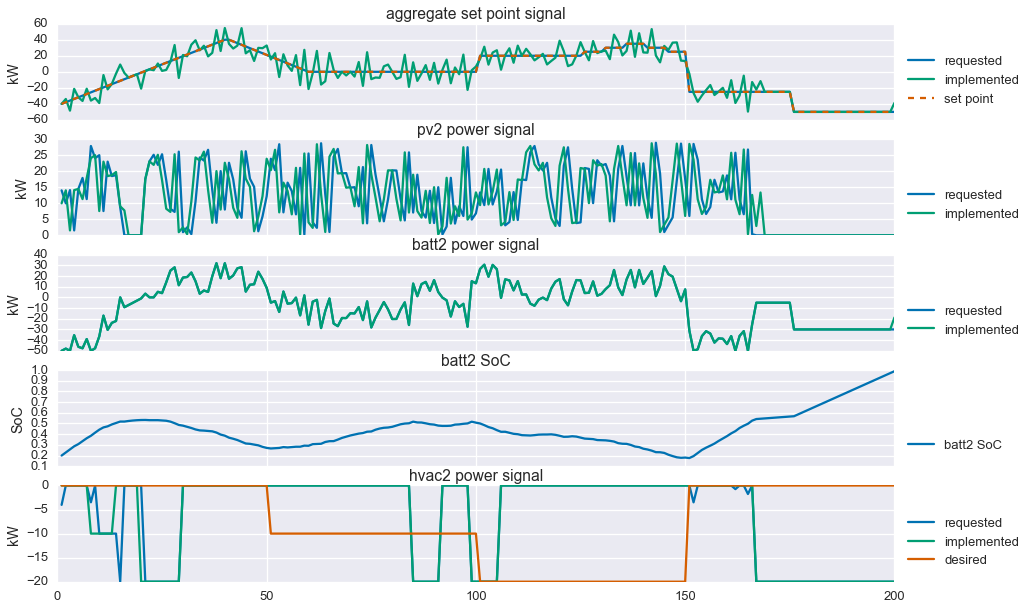

In [12]:
_ = controll_diffuse.plotReqImpPower()

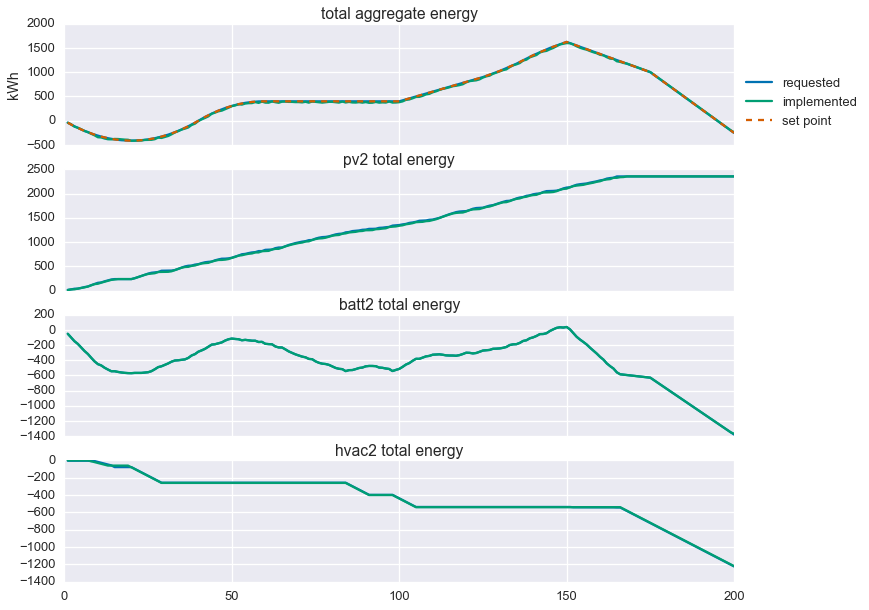

In [16]:
_ = controll_diffuse.plotReqImpTotalEnergy()

In [ ]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(14, 10))
ax[0].plot(range(1, 201), agg_point)
ax[0].plot(range(1, 201), output['PCC imp'])
ax[1].plot(range(1, 201), output['pv1 req'])
ax[1].plot(range(1, 201), output['pv1 imp'])
ax[2].plot(range(1, 201), output['batt1 req'])
ax[2].plot(range(1, 201), output['batt1 imp'])
ax[3].plot(range(1, 201), output['batt1 SoC'])
ax[4].plot(range(1, 201), output['hvac1 req'])
ax[4].plot(range(1, 201), output['hvac1 imp'])
ax[-1].set_xlabel('time step')
ax[0].set_ylabel('kW')
ax[1].set_ylabel('kW')
ax[2].set_ylabel('kW')
ax[3].set_ylabel('SoC')
ax[4].set_ylabel('kW')
ax[0].set_title('Aggregate Set Point Signal')
ax[1].set_title('PV Power Signal')
ax[2].set_title('Battery Power Signal')
ax[3].set_title('Battery SoC')
ax[4].set_title('TCL Power Signal')
ax[4].legend(['requested', 'implemented'], loc=(1.01, .1))
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(14, 8))
ax[0].plot(range(1, 201), np.cumsum(agg_point))
ax[0].plot(range(1, 201), np.cumsum(output['PCC imp']))
ax[1].plot(range(1, 201), np.cumsum(output['pv1 req']))
ax[1].plot(range(1, 201), np.cumsum(output['pv1 imp']))
ax[2].plot(range(1, 201), np.cumsum(output['batt1 req']))
ax[2].plot(range(1, 201), np.cumsum(output['batt1 imp']))
ax[3].plot(range(1, 201), np.cumsum(output['hvac1 req']))
ax[3].plot(range(1, 201), np.cumsum(output['hvac1 imp']))
ax[-1].set_xlabel('time step')
ax[0].set_ylabel('kWh')
ax[1].set_ylabel('kWh')
ax[2].set_ylabel('kWh')
ax[3].set_ylabel('kWh')
ax[0].set_title('Total Aggregate Energy')
ax[1].set_title('Total PV Energy')
ax[2].set_title('Total Battery Energy')
ax[3].set_title('Total TCL Energy')
ax[3].legend(['requested', 'implemented'], loc=(1.01, .1))
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(14, 12))
ax[0].plot(range(1, 201), agg_point)
ax[0].plot(range(1, 201), output2['PCC imp'])
ax[1].plot(range(1, 201), output2['pv2 req'])
ax[1].plot(range(1, 201), output2['pv2 imp'])
ax[2].plot(range(1, 201), output2['batt2 req'])
ax[2].plot(range(1, 201), output2['batt2 imp'])
ax[3].plot(range(1, 201), output2['batt2 SoC'])
ax[4].plot(range(1, 201), output2['hvac2 req'])
ax[4].plot(range(1, 201), output2['hvac2 imp'])
ax[-1].set_xlabel('time step')
ax[0].set_ylabel('kW')
ax[1].set_ylabel('kW')
ax[2].set_ylabel('kW')
ax[3].set_ylabel('SoC')
ax[4].set_ylabel('kW')
ax[0].set_title('Aggregate Set Point Signal')
ax[1].set_title('PV Power Signal')
ax[2].set_title('Battery Power Signal')
ax[3].set_title('Battery SoC')
ax[4].set_title('TCL Power Signal')
ax[4].legend(['requested', 'implemented'], loc=(1.01, .1))
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(14, 8))
ax[0].plot(range(1, 201), np.cumsum(agg_point))
ax[0].plot(range(1, 201), np.cumsum(output2['PCC imp']))
ax[1].plot(range(1, 201), np.cumsum(output2['pv2 req']))
ax[1].plot(range(1, 201), np.cumsum(output2['pv2 imp']))
ax[2].plot(range(1, 201), np.cumsum(output2['batt2 req']))
ax[2].plot(range(1, 201), np.cumsum(output2['batt2 imp']))
ax[3].plot(range(1, 201), np.cumsum(output2['hvac2 req']))
ax[3].plot(range(1, 201), np.cumsum(output2['hvac2 imp']))
ax[-1].set_xlabel('time step')
ax[0].set_ylabel('kWh')
ax[1].set_ylabel('kWh')
ax[2].set_ylabel('kWh')
ax[3].set_ylabel('kWh')
ax[0].set_title('Total Aggregate Energy')
ax[1].set_title('Total PV Energy')
ax[2].set_title('Total Battery Energy')
ax[3].set_title('Total TCL Energy')
ax[3].legend(['requested', 'implemented'], loc=(1.01, .1))
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(14, 4))
ax[0].plot(range(1, 201), agg_point)
ax[0].plot(range(1, 201), output['PCC imp'])

ax[1].plot(range(1, 201), np.cumsum(agg_point))
ax[1].plot(range(1, 201), np.cumsum(output['PCC imp']))

ax[-1].set_xlabel('time step')
ax[0].set_ylabel('kW')
ax[1].set_ylabel('kWh')

ax[0].set_title('Aggregate Set Point Signal')
ax[1].set_title('Total Aggregate Energy')

ax[1].legend(['requested', 'implemented'], loc=(1.01, .1))

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(14, 4))
ax[0].plot(range(1, 201), agg_point)
ax[0].plot(range(1, 201), output2['PCC imp'])

ax[1].plot(range(1, 201), np.cumsum(agg_point))
ax[1].plot(range(1, 201), np.cumsum(output2['PCC imp']))

ax[-1].set_xlabel('time step')
ax[0].set_ylabel('kW')
ax[1].set_ylabel('kWh')

ax[0].set_title('Aggregate Set Point Signal')
ax[1].set_title('Total Aggregate Energy')

ax[1].legend(['requested', 'implemented'], loc=(1.01, .1))